In [95]:
import findspark
findspark.init()

import pyspark


In [96]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField,StringType,IntegerType,StructType,DateType,FloatType
from pyspark.sql.functions import col,isnan, when, count,monotonically_increasing_id
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,15)
import numpy as np
import pandas as pd

In [97]:
spark = SparkSession \
    .builder \
    .appName("Tarea3") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

In [98]:
def EscribirDatosEnTabla(dataframe,NombreTabla):
    dataframe \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", NombreTabla) \
    .save()

def LeerDatosEnBD(NombreTabla):
    return spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", NombreTabla) \
    .load()


Dataset : Breast-Cancer.csv
El cáncer de mama es el cáncer más común entre las mujeres en el mundo. Representa el 25 % de todos los casos de cáncer y afectó a más de 2,1 millones de personas solo en 2015. Comienza cuando las células en el seno comienzan a crecer sin control. Estas células generalmente forman tumores que se pueden ver a través de rayos X o sentir como bultos en el área del seno.

La varaible a clasificar será Diagnosis (M - Maligno y  B - Benigno)

In [99]:
data_schema = StructType([
                StructField("id",IntegerType()),
                StructField("diagnosis",StringType()),
                StructField("radius_mean",FloatType()),
                StructField("texture_mean",FloatType()),
                StructField("perimeter_mean",FloatType()),
                StructField("area_mean",FloatType()),
                StructField("smoothness_mean",FloatType()),
                StructField("compactness_mean",FloatType()),
                StructField("concavity_mean",FloatType()),
                StructField("concave points_mean",FloatType()),
                StructField("symmetry_mean",FloatType()),
                StructField("fractal_dimension_mean",FloatType()),
                StructField("radius_se",FloatType()),
                StructField("texture_se",FloatType()),
                StructField("perimeter_se",FloatType()),
                StructField("area_se",FloatType()),
                StructField("smoothness_se",FloatType()),
                StructField("compactness_se",FloatType()),
                StructField("concavity_se",FloatType()),
                StructField("concave points_se",FloatType()),
                StructField("symmetry_se",FloatType()),
                StructField("fractal_dimension_se",FloatType()),
                StructField("radius_worst",FloatType()),
                StructField("texture_worst",FloatType()),
                StructField("perimeter_worst",FloatType()),
                StructField("area_worst",FloatType()),
                StructField("smoothness_worst",FloatType()),
                StructField("compactness_worst",FloatType()),
                StructField("concavity_worst",FloatType()),
                StructField("concave points_worst",FloatType()),
                StructField("symmetry_worst",FloatType()),
                StructField("fractal_dimension_worst",FloatType())]
)
            
data = spark.read.csv(
    'breast-cancer.csv',
    sep = ',',
    header = True,
    schema = data_schema
    )

data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: float (nullable = true)
 |-- texture_mean: float (nullable = true)
 |-- perimeter_mean: float (nullable = true)
 |-- area_mean: float (nullable = true)
 |-- smoothness_mean: float (nullable = true)
 |-- compactness_mean: float (nullable = true)
 |-- concavity_mean: float (nullable = true)
 |-- concave points_mean: float (nullable = true)
 |-- symmetry_mean: float (nullable = true)
 |-- fractal_dimension_mean: float (nullable = true)
 |-- radius_se: float (nullable = true)
 |-- texture_se: float (nullable = true)
 |-- perimeter_se: float (nullable = true)
 |-- area_se: float (nullable = true)
 |-- smoothness_se: float (nullable = true)
 |-- compactness_se: float (nullable = true)
 |-- concavity_se: float (nullable = true)
 |-- concave points_se: float (nullable = true)
 |-- symmetry_se: float (nullable = true)
 |-- fractal_dimension_se: float (nullable = true)
 |-- radius_worst: float (nul

In [100]:
data.show(n=10,truncate=False)

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|id      |diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+---------+-----------+------------+---

Contamos los valores nulos

In [101]:

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+---+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
| id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---+---------+-----------+------------+--------------+---

Se hace un encoder para la columna diagnosis

In [102]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="diagnosis", outputCol="diagnosisIndex") 
indexed = indexer.fit(data).transform(data) 
indexed.select("diagnosis","diagnosisIndex").show()
data=indexed



+---------+--------------+
|diagnosis|diagnosisIndex|
+---------+--------------+
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        M|           1.0|
|        B|           0.0|
+---------+--------------+
only showing top 20 rows



Creación de graficas



569


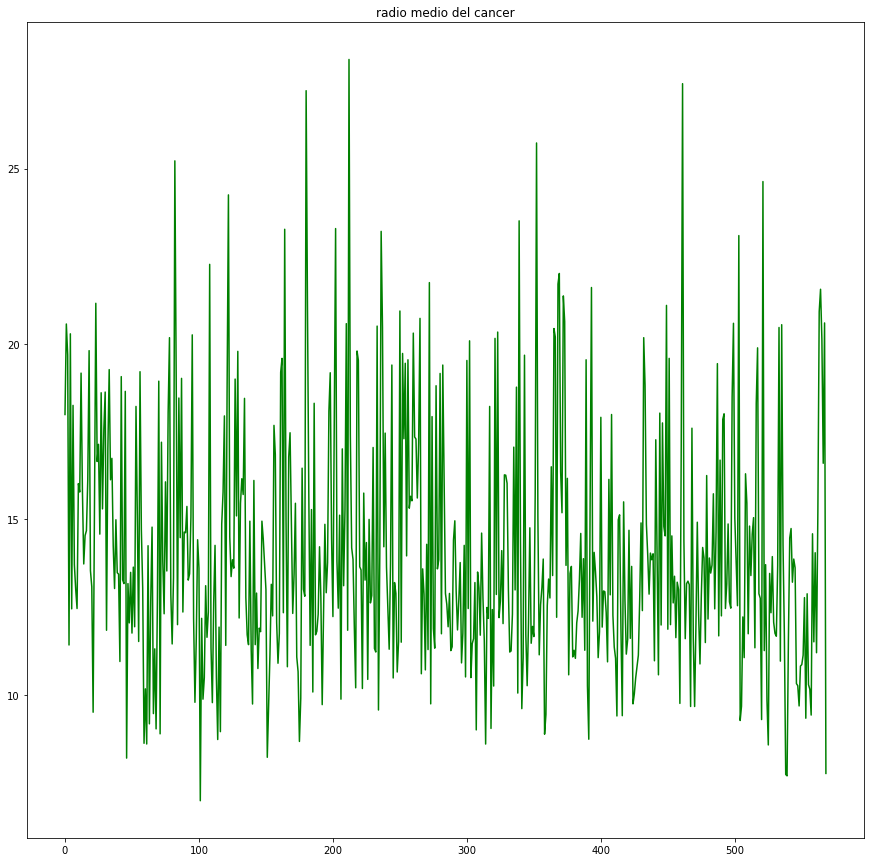

In [103]:
y=data.toPandas()["radius_mean"].values.tolist()
x = np.arange(0, len(y))
print(len(y))
plt.title("radio medio del cancer")

plt.plot(x, y, color ="green")








plt.show()

569


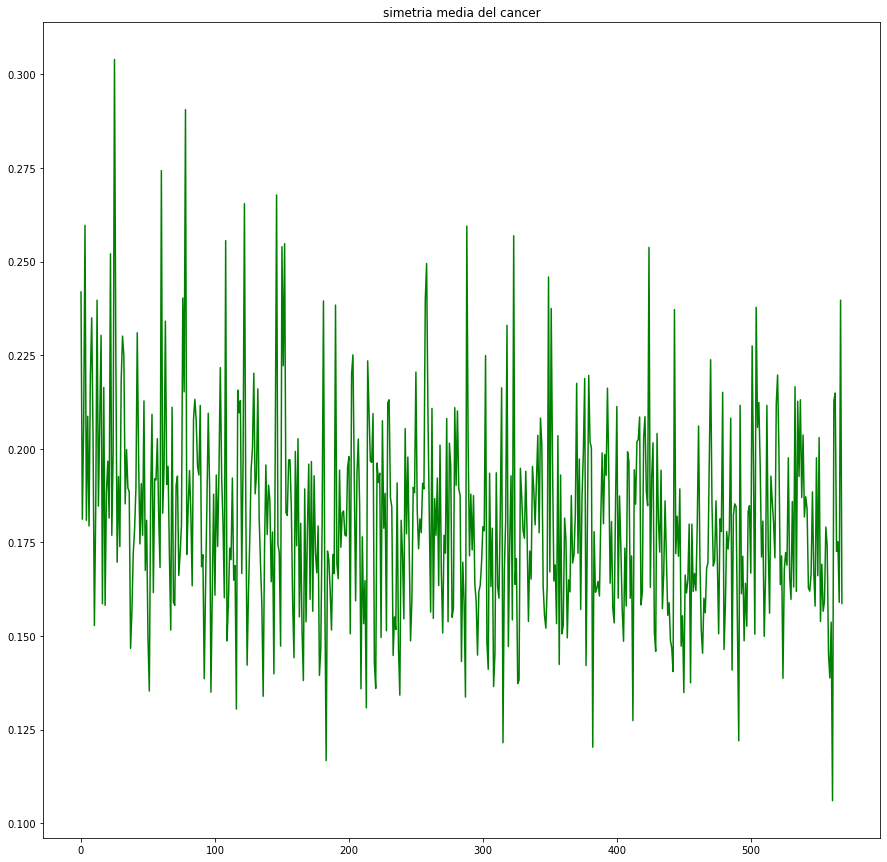

In [104]:
y=data.toPandas()["symmetry_mean"].values.tolist()
x = np.arange(0, len(y))
print(len(y))
plt.title("simetria media del cancer")

plt.plot(x, y, color ="green")

569


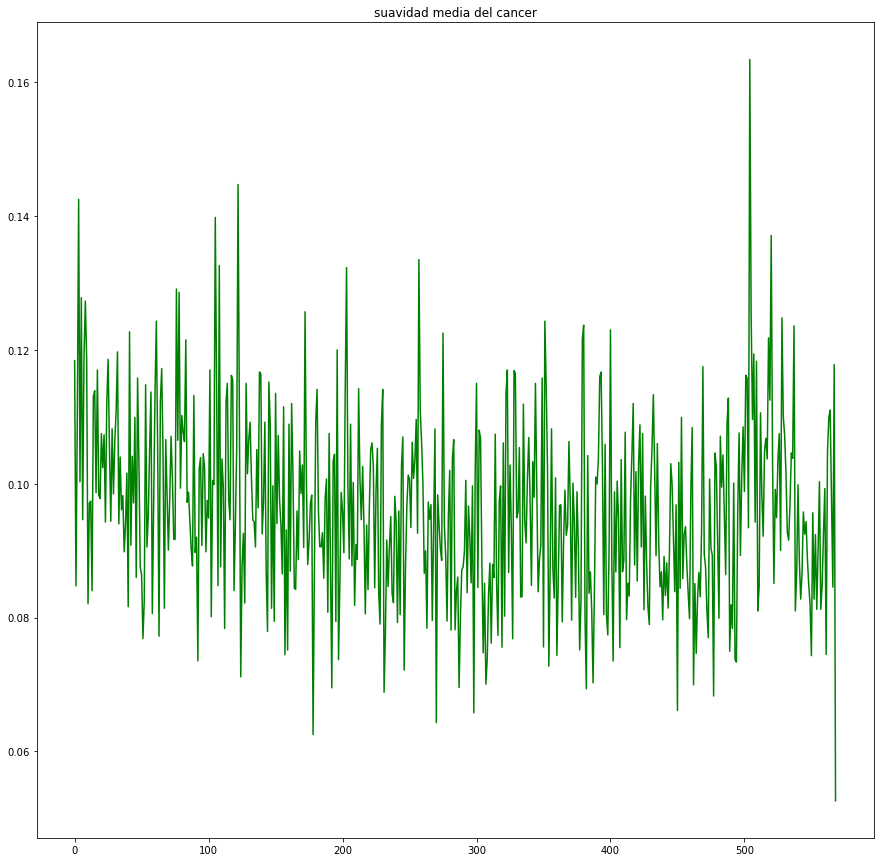

In [105]:
y=data.toPandas()["smoothness_mean"].values.tolist()
x = np.arange(0, len(y))
print(len(y))
plt.title("suavidad media del cancer")

plt.plot(x, y, color ="green")

569


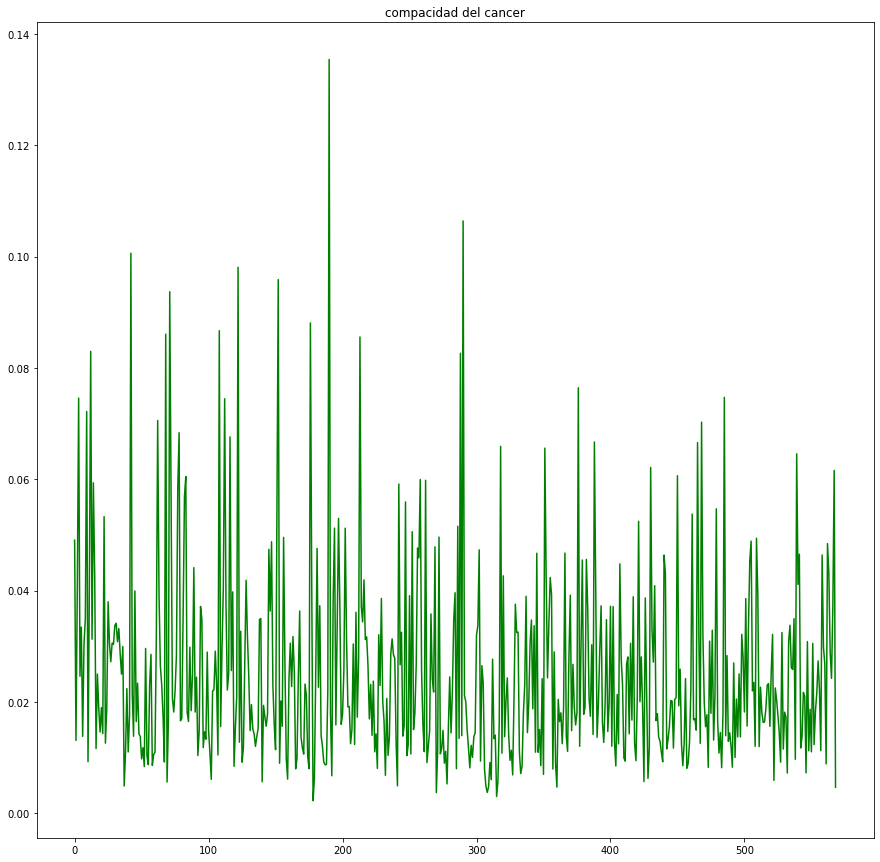

In [106]:
y=data.toPandas()["compactness_se"].values.tolist()
x = np.arange(0, len(y))
print(len(y))
plt.title("compacidad del cancer")

plt.plot(x, y, color ="green")


<AxesSubplot:>

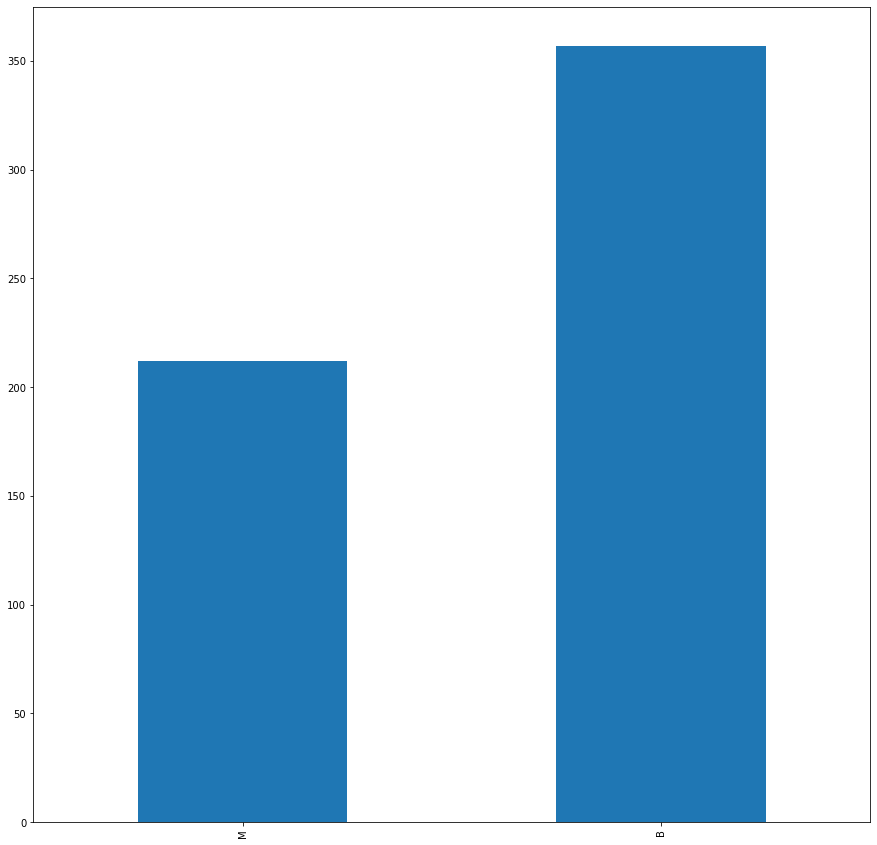

In [107]:
x=data.toPandas()["diagnosis"].values.tolist()

pd.Series(x).value_counts(sort=False).plot(kind='bar')

De las columnas analizadas ninguna parece seguir una distribución clara

Creamos vectores para poder crear la correlacion 

C:\Spark\spark-3.2.0-bin-hadoop3.2\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<AxesSubplot:>

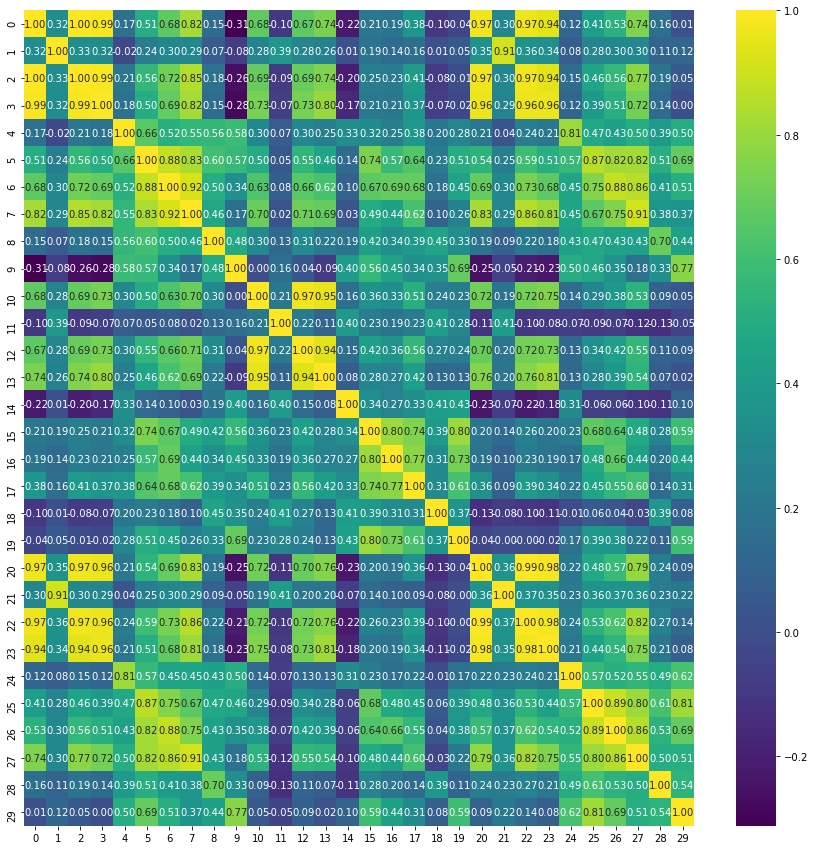

In [108]:
from pyspark.ml.feature import VectorAssembler
def  vectorizar(dataframe):
    assembler = VectorAssembler(
                    inputCols=[
                "radius_mean",
                "texture_mean",
                "perimeter_mean",
                "area_mean",
                "smoothness_mean",
                "compactness_mean",
                "concavity_mean",
                "concave points_mean",
                "symmetry_mean",
                "fractal_dimension_mean",
                "radius_se",
                "texture_se",
                "perimeter_se",
                "area_se",
                "smoothness_se",
                "compactness_se",
                "concavity_se",
                "concave points_se",
                "symmetry_se",
                "fractal_dimension_se",
                "radius_worst",
                "texture_worst",
                "perimeter_worst",
                "area_worst",
                "smoothness_worst",
                "compactness_worst",
                "concavity_worst",
                "concave points_worst",
                "symmetry_worst",
                "fractal_dimension_worst"],
                    outputCol='features')

    vector_df = assembler.transform(dataframe)
    vector_df = vector_df.select(['features', 'diagnosisIndex'])
    return vector_df
vector_df=vectorizar(data)

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

Estandarización


In [109]:
from pyspark.ml.feature import StandardScaler
def Escalador(dataframe):
    standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
    scale_model = standard_scaler.fit(dataframe)

    scaled_df = scale_model.transform(dataframe)
   
    return scaled_df
scaled_df=Escalador(vector_df)
scaled_df.show()

+--------------------+--------------+--------------------+
|            features|diagnosisIndex|              scaled|
+--------------------+--------------+--------------------+
|[17.9899997711181...|           1.0|[5.10492354842578...|
|[20.5699996948242...|           1.0|[5.83703597383050...|
|[19.6900005340576...|           1.0|[5.58732343933651...|
|[11.4200000762939...|           1.0|[3.24059077566479...|
|[20.2900009155273...|           1.0|[5.75758225620134...|
|[12.4499998092651...|           1.0|[3.53286814968446...|
|[18.25,19.9799995...|           1.0|[5.17870238710847...|
|[13.7100000381469...|           1.0|[3.89041150272926...|
|[13.0,21.81999969...|           1.0|[3.68893868670740...|
|[12.4600000381469...|           1.0|[3.53570585977662...|
|[16.0200004577636...|           1.0|[4.54590764997805...|
|[15.7799997329711...|           1.0|[4.47780396086076...|
|[19.1700000762939...|           1.0|[5.43976576197112...|
|[15.8500003814697...|           1.0|[4.49766766088698..

Escritura a la BD con los datos limpios sin vecotorizar ni escalar

In [ ]:
EscribirDatosEnTabla(data,"tarea3")

Lectura de datos

In [ ]:
data=LeerDatosEnBD("tarea3")
data.show()
data=data.drop("id")

In [ ]:
train, test = data.randomSplit([0.7, 0.3], seed = 2)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
train.printSchema()

Random Forest

Sin usar CrossValidation

In [ ]:
train.printSchema()
train=vectorizar(train)

train=Escalador(train)

testData=vectorizar(test)
testData=Escalador(testData)


In [ ]:



rf = RandomForestClassifier(featuresCol = 'scaled', labelCol = 'diagnosisIndex', numTrees=15)
rfModel = rf.fit(train)
predictions = rfModel.transform(testData)



evaluator = MulticlassClassificationEvaluator(
    labelCol="diagnosisIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

predictions.printSchema()
predictions=predictions.withColumnRenamed("prediction","Prediccion")
predictions.select("diagnosisIndex", "Prediccion").show(30)
predictions=predictions.select("Prediccion")
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Usando CrossValidation

In [ ]:
rf = RandomForestClassifier(featuresCol = 'scaled', labelCol = 'diagnosisIndex')
evaluator = MulticlassClassificationEvaluator(
    labelCol="diagnosisIndex", predictionCol="prediction", metricName="accuracy")
rfparamGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rf.maxDepth, [2, 5, 10])
             #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
               .addGrid(rf.maxBins, [5, 10, 20])
             #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)

rfModel = rfcv.fit(train)

predictions = rfModel.transform(testData)



accuracy = evaluator.evaluate(predictions)
predictions.printSchema()
predictions=predictions.withColumnRenamed("prediction","Prediccion")
predictions.select("diagnosisIndex", "Prediccion").show(30)
predictions=predictions.select("Prediccion")
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Escritura de la predicción con crossvalidation a postgres

In [ ]:

results=test.withColumn("mid",monotonically_increasing_id()).\
join(predictions.withColumn("mid",monotonically_increasing_id()),["mid"]).\
drop("mid")
results.printSchema()
results.show(3)
EscribirDatosEnTabla(results,"modelo1")


Decision Tree

Sin usar CrossValidation

In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'scaled', labelCol = 'diagnosisIndex',  maxDepth=15)
rfModel = dt.fit(train)
predictions = rfModel.transform(testData)



evaluator = MulticlassClassificationEvaluator(
    labelCol="diagnosisIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

predictions.printSchema()
predictions=predictions.withColumnRenamed("prediction","Prediccion")
predictions.select("diagnosisIndex", "Prediccion").show(30)
predictions=predictions.select("Prediccion") 

print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Usando CrossValidation

In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'scaled', labelCol = 'diagnosisIndex',  maxDepth=15)
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             .build())
evaluator = MulticlassClassificationEvaluator(
    labelCol="diagnosisIndex", predictionCol="prediction", metricName="accuracy")

dtcv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)   
dtcvModel = dtcv.fit(train)
print(dtcvModel)

predictions = rfModel.transform(testData)




accuracy = evaluator.evaluate(predictions)
predictions.printSchema()
predictions=predictions.withColumnRenamed("prediction","Prediccion")
predictions.select("diagnosisIndex", "Prediccion").show(30)
predictions=predictions.select("Prediccion")
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Escritura del modelo 2 a postgres

In [ ]:
results=test.withColumn("mid",monotonically_increasing_id()).\
join(predictions.withColumn("mid",monotonically_increasing_id()),["mid"]).\
drop("mid")
results.printSchema()
results.show(3)
EscribirDatosEnTabla(results,"modelo2")